1. downloading tfa through pip killed kernal. 
2. we went the source file for the tfa pairwise distance function 


Tomorrow:
1. compare pairwise_distance() output to the one in Zhaoyang's code
2. custom loss funtion

Notes
1. tensorflow has its own gradient descent, but you can make a custom optimizer. 

Our idea:
1. make own custom loss function and custom optizer.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model

from data_generation import *

In [2]:
import gudhi               as gd
from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


In [32]:
np.random.seed(100)
n_features=3
n_samples=1000
epochs=10
X = unif_cylinder(n_samples=n_samples, radius=1, height=100, n_features=n_features)
X = normalize(X.reshape(n_samples,n_features))

In [35]:
#change P to our projected data
model = RipsModel(P=X, mel=12, dim=1, card = 150)

In [37]:
sinkhorn_distance()

AttributeError: 'int' object has no attribute 'numpy'

In [34]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        #DX = tfa.losses.metric_learning.pairwise_distance(X)
        DX = pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        #Z=X@self.P
        Z = P #projected data
        
        # Compute distance matrix
        #DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZ = pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

In [30]:
def sinkhorn_distance():    
    Zdgm = model.call()[1] #projected persistence diagram
    Xdgm = model.call()[0] #original persistence diagram
    npX = np.array(Xdgm)
    npZ = np.array(Zdgm)

    #Question: Why are all these functions defined in the loop? Can we take them out? 

    #computing Sinkhorn distance <<<- estimation of wasserstein
    def dmat(x, y):
        """
        :param x: (na, 2)
        :param y: (nb, 2)
        :return:
        """
        mmp1 = tf.tile(tf.expand_dims(x, axis=1), [1, y.shape[0], 1])  # (na, nb, 2)
        mmp2 = tf.tile(tf.expand_dims(y, axis=0), [x.shape[0], 1, 1])  # (na, nb, 2)

        mm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(mmp1, mmp2)), axis=2))  # (na, nb)

        return mm

    def sink(M, m_size, reg, numItermax=1000, stopThr=1e-9):
        # we assume that no distances are null except those of the diagonal of distances
        # M: extended cost matrix
        # reg: lambda

        a = tf.expand_dims(tf.ones(shape=(m_size[0],)) / m_size[0], axis=1)  # (na, 1)
        b = tf.expand_dims(tf.ones(shape=(m_size[1],)) / m_size[1], axis=1)  # (nb, 1)

        # init data
        Nini = m_size[0]
        Nfin = m_size[1]

        u = tf.expand_dims(tf.ones(Nini) / Nini, axis=1)  # (na, 1)
        v = tf.expand_dims(tf.ones(Nfin) / Nfin, axis=1)  # (nb, 1)

        K = tf.exp(-M / reg)  # (na, nb)

        Kp = (1.0 / a) * K  # (na, 1) * (na, nb) = (na, nb)

        cpt = tf.constant(0)
        err = tf.constant(1.0)

        c = lambda cpt, u, v, err: tf.logical_and(cpt < numItermax, err > stopThr)

        def err_f1():
            # we can speed up the process by checking for the error only all the 10th iterations
            transp = u * (K * tf.squeeze(v))  # (na, 1) * ((na, nb) * (nb,)) = (na, nb)
            err_ = tf.pow(tf.norm(tf.reduce_sum(transp) - b, ord=1), 2)  # (,)
            return err_

        def err_f2():
            return err

        def loop_func(cpt, u, v, err):
            KtransposeU = tf.matmul(tf.transpose(K, (1, 0)), u)  # (nb, na) x (na, 1) = (nb, 1)
            v = tf.compat.v1.div(b,KtransposeU)  # (nb, 1)
            u = 1.0 / tf.matmul(Kp, v)  # (na, 1)

            err = tf.cond(tf.equal(cpt % 10, 0), err_f1, err_f2)

            cpt = tf.add(cpt, 1)
            return cpt, u, v, err

        _, u, v, _ = tf.while_loop(c, loop_func, loop_vars=[cpt, u, v, err])

        result = tf.reduce_sum(u * K * tf.reshape(v, (1, -1)) * M)

        return result

    A=np.array([[1,-1],[-1,1]])
    # Compute persistence diagram


    # Loss is sum of squares of distances to the diagonal
    Morginal = dmat(Xdgm,Zdgm)

    n1,n2 = Morginal.shape
    Deltax=np.zeros(shape=(n1,1))
    Deltaz=np.zeros(shape=(1,n2+1))

    for i in range(n1):
        Deltax[i,0] = 1/2*npX[i,:]@A@npX[i,:].T

    for j in range(n2):
        Deltaz[0,j] = 1/2*npZ[j,:]@A@npZ[j,:].T


    M=tf.square(tf.concat([tf.concat([Morginal,Deltax],1),Deltaz],0))

    # Sinkhorn distance as loss
    loss = sink(M,(n1+1,n2+1),0.05)
    
    return loss

In [31]:
def pairwise_distance(X, squared: bool = False):
    feature = tf.convert_to_tensor(X,dtype = tf.float32)
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      feature: 2-D Tensor of size `[number of data, feature dimension]`.
      squared: Boolean, whether or not to square the pairwise distances.
    Returns:
      pairwise_distances: 2-D Tensor of size `[number of data, number of data]`.
    """
    pairwise_distances_squared = (
        tf.math.add(
            tf.math.reduce_sum(tf.math.square(feature), axis=[1], keepdims=True),
            tf.math.reduce_sum(
                tf.math.square(tf.transpose(feature)), axis=[0], keepdims=True
            ),
        )
        - 2.0 * tf.matmul(feature, tf.transpose(feature))
    )

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = tf.math.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = tf.math.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = tf.math.sqrt(
            pairwise_distances_squared
            + tf.cast(error_mask, dtype=tf.dtypes.float32) * 1e-16
        )

    # Undo conditionally adding 1e-16.
    pairwise_distances = tf.math.multiply(
        pairwise_distances,
        tf.cast(tf.math.logical_not(error_mask), dtype=tf.dtypes.float32),
    )

    num_data = tf.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = tf.ones_like(pairwise_distances) - tf.linalg.diag(
        tf.ones([num_data])
    )
    pairwise_distances = tf.math.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

In [24]:
T = tf.convert_to_tensor(X,dtype = tf.float32)

In [25]:
pairwise_distance(T)

<tf.Tensor: id=114, shape=(1000, 1000), dtype=float32, numpy=
array([[0.        , 0.85770124, 1.8581127 , ..., 0.7631829 , 0.87576705,
        1.4929303 ],
       [0.85770124, 0.        , 1.384858  , ..., 0.63010794, 0.60666794,
        1.2108058 ],
       [1.8581127 , 1.384858  , 0.        , ..., 1.6415342 , 1.565613  ,
        1.2997197 ],
       ...,
       [0.7631829 , 0.63010794, 1.6415342 , ..., 0.        , 0.13407879,
        0.8960985 ],
       [0.87576705, 0.60666794, 1.565613  , ..., 0.13407879, 0.        ,
        0.8091402 ],
       [1.4929303 , 1.2108058 , 1.2997197 , ..., 0.8960985 , 0.8091402 ,
        0.        ]], dtype=float32)>

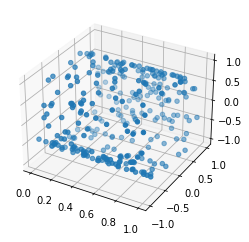

In [3]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
plt.show()

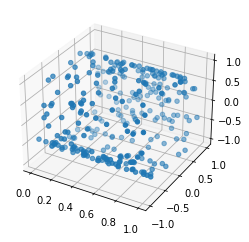

In [4]:
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)

ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
plt.show()

In [5]:
st = gd.RipsComplex(points = X, 
                    max_edge_length = 100).create_simplex_tree(max_dimension=2)
st.persistence() #computes persistence intervals

#extract persistence intervals for specified dim
D = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)

In [6]:
#the perfect circle case
# remove x axis
st1 = gd.RipsComplex(points = X@np.array([[0,  0],
       [1 , -0 ],
       [ 0. , 1]]), 
                    max_edge_length=12).create_simplex_tree(max_dimension=2)
st1.persistence()
D1 = np.array(st1.persistence_intervals_in_dimension(1), dtype=np.float32)

In [7]:
wasserstein_distance(tf.constant(D1), tf.constant(D), order=2, internal_p=2)

2022-02-02 17:33:27.570766: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-02 17:33:27.572090: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([], dtype=int64)

In [ ]:
class CustomAccuracy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Z):

        modelR = RipsModel(P=Z, mel=12, dim=1, card = 150)

        # Compute persistence diagram
        Zdgm = modelR.call()[1]
        Xdgm = modelR.call()[0]


        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))

        return 

model.compile(optimizer=Adam(learning_rate=0.001), loss=CustomAccuracy(), metrics=['mae', 'mse'])

In [ ]:
#change P to our projected data
model = RipsModel(P=P, mel=12, dim=1, card = 150)

# Compute persistence diagram
Zdgm = model.call()[1]
Xdgm = model.call()[0]


# Loss is Wasserstein distance
loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))

In [12]:
np.random.seed(100)
n_features=3
n_samples=1000
epochs=10
X = unif_cylinder(n_samples=n_samples, radius=1, height=100, n_features=n_features)
X = normalize(X.reshape(n_samples,n_features))

In [15]:
X.shape[1:]

(3,)

In [18]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(2)
        ])

In [20]:
model.compile(optimizer='adam', loss = losses.MeanSquaredError(),
              metrics=['accuracy'])

In [22]:
model.fit(X, X, epochs=5)

ValueError: A target array with shape (1000, 3) was passed for an output of shape (None, 2) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

In [7]:
class Autoencoder(Model):
    def __init__(self, original_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
#         self.decoder = tf.keras.Sequential([
#           layers.Dense(np.product(original_dim), activation='sigmoid'),
#           layers.Reshape(original_dim)
#         ])

    def call(self, x):
        encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
        return encoded #decoded

In [8]:
def plot3d(X):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1,2,2,projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(X[:,0],X[:,1],X[:,2])
    ax.view_init(45,0)

In [10]:
np.random.seed(100)
n_features=3
n_samples=1000
epochs=10
X = unif_cylinder(n_samples=n_samples, radius=1, height=100, n_features=n_features)
X = normalize(X.reshape(n_samples,n_features))

autoencoder = Autoencoder((3,), 3)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(X, X,
                epochs=epochs,
                shuffle=True)

    def call(self, x):
        encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
        return encoded #decoded

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x):
        encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
        return encoded #decoded

This may be caused by multiline strings or comments not indented at the same level as the code.
Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s 302us/sample - loss: 0.3449
Epoch 2/10
1000/1000 [==============================] - 0s 32us/sample - loss: 0.3262
Epoch 3/10
1000/1000 [==============================] - 0s 33us/sample - loss: 0.3101
Epoch 4/10
1000/1000 [==============================] - 0s 33us/sample - loss: 0.2965
Epoch 5/10
1000/1000 [==============================] - 0s 31us/sample - loss: 0.2852
Epoch 6/10
1000/1000 [==============================] - 0s 33us/sample - loss: 0.2754
Epoch


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1000, 3)


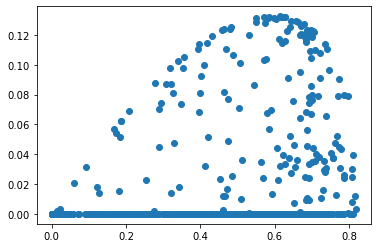

In [11]:
X_new = autoencoder.encoder(X).numpy()
print(X_new.shape)
plt.scatter(X_new[:,0],X_new[:,1])